In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataAnalysisTools import *
import pickle

# Establishing Class for Analysis


In [2]:
class eagleDataComparison():
    def __init__(self, simulation1, simulation2, randNum):
        
        #Defining Values
        self.ageUniverse = 13.799
        self.massPrecision = 0.05
        self.randNum = randNum

        #Defining all the Storage Tables
        self.Data1 = astropy.table.Table()
        self.Data2 = astropy.table.Table()
        self.ComparisonData = {}
        self.TimeData = astropy.table.Table()
        self.Medians = {}
        self.pairingStorage = {}
        self.BinnedValues = {}
        self.PropertiesQueried = []
        
        # DataBase Connection
        self.con = sql.connect("scp763", password="ih39ztr2")
        self.sim1 = simulation1
        self.sim2 = simulation2






    
    def generateQueries(self, querySelection, simulation, rand):

        ######Defining Some Useful Queries
        #All Projenitor Galaxies
        
        if querySelection == "ProgenitorGalaxies":
            self.query = "\
                SELECT \
                    ProgGal.SnapNum as SnapShot, \
                    ProgGal.GalaxyID as GalaxyID, \
                    ProgGal.TopLeafID as TopLeafID, \
                    ProgGal.Redshift as Z, \
                    ProgGal.StarFormationRate as SFR, \
                    ProgGal.MassType_DM as DMmass, \
                    ProgGal.MassType_Star as SM, \
                    ProgGal.BlackHoleMass as sgBHM, \
                    ProgGal.MassType_BH as pBHM, \
                    ProgGal.BlackHoleMassAccretionRate as iBMAR, \
                    ProgGal.Vmax as Vmax, \
                    ProgGal.RandomNumber as RandNum \
                FROM \
                    {}_SubHalo as RefGal, \
                    {}_SubHalo as ProgGal \
                WHERE \
                    RefGal.TopLeafID = ProgGal.TopLeafID AND \
                    RefGal.SnapNum = 28 AND \
                    RefGal.SubGroupNumber = 0 AND \
                    RefGal.RandomNumber < {} \
                ORDER BY \
                    ProgGal.TopLeafID, \
                    ProgGal.Redshift".format(simulation, simulation, rand)
        
        #Reference Galaxies

        elif querySelection == "ReferenceGalaxies":
            self.query = "\
                SELECT \
                    SH.MassType_DM as DMmass, \
                    SH.MassType_Star as SM, \
                    SH.BlackHoleMassAccretionRate as BMAR, \
                    SH.BlackHoleMass as sgBHM, \
                    SH.MassType_BH as pBHM, \
                    SH.StarFormationRate as SFR, \
                    (Mag.g_nodust - Mag.r_nodust) as GR, \
                    (Mag.r_nodust) as R, \
                    (Mag.g_nodust) as G \
                FROM \
                    {}_SubHalo as SH, \
                    {}_Magnitudes as Mag \
                WHERE \
                    SH.GalaxyID = Mag.GalaxyID AND \
                    SH.SnapNum = 28 AND \
                    SH.SubGroupNumber = 0".format(simulation, simulation)

        #Comparison Query

        elif querySelection == "ComparisonGalaxies":
            print("Selected Comparison Queries")
            self.query = "\
                SELECT \
                    fof.GroupCentreOfPotential_x as x, \
                    fof.GroupCentreOfPotential_y as y, \
                    fof.GroupCentreOfPotential_z as z, \
                    fof.GroupMass as Mass, \
                    fof.Group_R_Mean500 as radius, \
                    fof.GroupID as GroupID, \
                    SH.Vmax as Vmax, \
                    SH.MassType_DM as DMmass, \
                    SH.MassType_Star as SM, \
                    SH.BlackHoleMassAccretionRate as BMAR, \
                    SH.BlackHoleMass as sgBHM, \
                    SH.MassType_BH as pBHM, \
                    SH.StarFormationRate as SFR, \
                    SH.SnapNum as SnapShot, \
                    SH.GalaxyID as GalaxyID \
                FROM \
                    {}_FOF as fof, \
                    {}_Subhalo as SH \
                WHERE \
                    SH.SubGroupNumber = 0 AND \
                    SH.GroupID = fof.GroupID AND \
                    fof.RandomNumber < {}".format(simulation, simulation, rand)

        #Test Query
        elif querySelection == "TestGalaxies":
            self.query = "\
                SELECT \
                    fof.GroupCentreOfPotential_x as x, \
                    fof.GroupCentreOfPotential_y as y, \
                    fof.GroupCentreOfPotential_z as z, \
                    fof.GroupMass as Mass, \
                    fof.Group_R_Mean200 as radius, \
                    fof.GroupID as GroupID, \
                    SH.Vmax as Vmax, \
                    SH.StarFormationRate as SFR \
                FROM \
                    {}_FOF as fof, \
                    {}_Subhalo as SH \
                WHERE \
                    SH.GroupID = fof.GroupID AND \
                    fof.RandomNumber < {} \
                ORDER BY \
                    fof.GroupMass DESC".format(simulation, simulation, rand)


    def DBquery(self,query,linkTime = True):
        #Get SnapShot Data
        queryLookBack = " \
            SELECT \
                SN.SnapNum as SnapNum, \
                SN.Redshift as Z, \
                SN.LookbackTime as LookBackTime, \
                Round(SN.Redshift, 2) as refZ \
            FROM \
                Snapshots as SN"
        SNdata = sql.execute_query(self.con, queryLookBack)
        for label in SNdata.dtype.names:
            self.TimeData[label] = SNdata[label]
        del SNdata, queryLookBack
        self.TimeData['AgeOfUniverse'] = self.ageUniverse - self.TimeData['LookBackTime']

        ###################################################################################

        #Get QueryData
        self.generateQueries(query,self.sim1,self.randNum)

        print('Querying Database Sim1 ...')
        ts = time.time()
        tdata = sql.execute_query(self.con, self.query)
        queryTime = time.time() - ts
        t = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        log = '{}   |  Query Time: {}s'.format(t,round(queryTime,2))
        print(log)
        del ts, queryTime, t , log

        print('Sorting Data Sim1 ...')
        ts = time.time()
        for label in tdata.dtype.names:
            self.Data1[label] = tdata[label]
        sortTime = time.time() - ts
        t = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        log = '{}   |  Sort Time: {}s'.format(t,round(sortTime,2))
        print(log)
        del ts, sortTime, t , log, tdata


        # Doing some quick Data Manipulation
        # Calculate Lookback Times and Proper Times
        print('Organising Data Sim1 ...')
        ts = time.time()

        if linkTime:
            snapShotDataReference = {}
            for LB, z in zip(self.TimeData['LookBackTime'], self.TimeData['Z']):
                snapShotDataReference[str(round(z,2))] = LB
            LB = []
            for z in self.Data1['Z']:
                z = str(round(z,2))
                LB.append(snapShotDataReference[z])

            self.Data1['LookBackTime'] = LB
            self.Data1['time'] =  self.ageUniverse - self.Data['LookBackTime']

            del snapShotDataReference, LB
        
        calcTime = time.time() - ts
        t = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        log = '{}   |  Sort Time: {}s'.format(t,round(calcTime,2))
        print(log)

        del  ts, calcTime, t, log

        ##############################################################################

        #Get QueryData
        self.generateQueries(query,self.sim2,self.randNum)

        print('Querying Database Sim2 ...')
        ts = time.time()
        tdata = sql.execute_query(self.con, self.query)
        queryTime = time.time() - ts
        t = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        log = '{}   |  Query Time: {}s'.format(t,round(queryTime,2))
        print(log)
        del ts, queryTime, t , log

        print('Sorting Data Sim1 ...')
        ts = time.time()
        for label in tdata.dtype.names:
            self.Data2[label] = tdata[label]
        sortTime = time.time() - ts
        t = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        log = '{}   |  Sort Time: {}s'.format(t,round(sortTime,2))
        print(log)
        del ts, sortTime, t , log, tdata


        # Doing some quick Data Manipulation
        # Calculate Lookback Times and Proper Times
        print('Organising Data Sim1 ...')
        ts = time.time()

        if linkTime:
            snapShotDataReference = {}
            for LB, z in zip(self.TimeData['LookBackTime'], self.TimeData['Z']):
                snapShotDataReference[str(round(z,2))] = LB
            LB = []
            for z in self.Data2['Z']:
                z = str(round(z,2))
                LB.append(snapShotDataReference[z])

            self.Data2['LookBackTime'] = LB
            self.Data2['time'] =  self.ageUniverse - self.Data['LookBackTime']

            del snapShotDataReference, LB
        
        calcTime = time.time() - ts
        t = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        log = '{}   |  Sort Time: {}s'.format(t,round(calcTime,2))
        print(log)

        del  ts, calcTime, t, log

        self.PropertiesQueried = self.Data1.dtype.names



    def linkGalaxies(self, SnapShots, numToLink , massPrecision):
        t = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
 

        ################################################################
        tsTotal = time.time()

        for SN in SnapShots:
            firstLoop = 0
            # print("Reset tFirst")
            tFirst = time.time()    

            ##########################################################

            matchedGalID1 = []
            matchedMass1 = []
            matchedVmax1 = []
            matchedDMmass1 = []
            matchedSM1 = []
            matchedSFR1 = []
            matchedsgBHM1 = []

            ##########################################################

            matchedGalID2 = []
            matchedMass2 = []
            matchedVmax2 = []
            matchedDMmass2 = []
            matchedSM2 = []
            matchedSFR2 = []
            matchedsgBHM2 = []

            ##########################################################
            ##########################################################

            unmatchedGalID1 = []
            unmatchedMass1 = []
            unmatchedVmax1 = []
            unmatchedDMmass1 = []
            unmatchedSM1 = []
            unmatchedSFR1 = []
            unmatchedsgBHM1 = []

            ##########################################################
            ##########################################################
            ##########################################################

            print("Linking SnapShot {}:".format(SN))
            unmatchedGal = 0 
            multiMatchedGal = 0
            matchedGal = 0

            #############################################################

            maskSelectAGN = (self.Data1['SnapShot'] == SN)
            maskSelectNoAGN = (self.Data2['SnapShot'] == SN)

            if numToLink == "All":
                GalaxiesToMatch = self.Data1[maskSelectAGN]
            else:
                GalaxiesToMatch = self.Data1[maskSelectAGN][:numToLink]
            GalaxiesToCheck = self.Data2[maskSelectNoAGN]

            #############################################################

            rCheck = np.array([GalaxiesToCheck['x'],GalaxiesToCheck['y'],GalaxiesToCheck['z']])
            

            massCheck = np.array(GalaxiesToCheck['Mass'])
            massMatch = np.array(GalaxiesToMatch['Mass'])

            ###############################################################
            
            ts = time.time()

            ###############################################################


            for Gal in GalaxiesToMatch:
                # print("Galaxy To Match:")
                # print(Gal)
                # print("\n Guess:")
                # print(GalaxiesToCheck[0])
                # print("\n \n")
                #Radius Test

                dr = np.sqrt(sum( np.array( [
                    rCheck[0] - Gal['x'],
                    rCheck[1] - Gal['y'],
                    rCheck[2] - Gal['z']
                ])**2))

                # print(dr)
                # print('\n \n')

                maskRadius = dr < (Gal['radius']/1000)
                
                # print('Masked Results: SEPARATION')
                # print(maskRadius)
                # print('\n \n')

                # print('Matching Galaxies: SEPARATION')
                # print(GalaxiesToCheck[maskRadius])
                # print("\n \n")


                #Mass Check
                dm = (massCheck - Gal['Mass']) / Gal['Mass']
                # print('Mass Differences:')
                # print(dm)
                # print('\n \n')

                maskMass = ( dm < (0 + massPrecision) )  &  ( dm > (0 - massPrecision) )

                # print('Masked Results: MASS')
                # print(maskMass)
                # print('\n \n')

                # print('Matching Galaxies: MASS')
                # print(GalaxiesToCheck[maskMass])
                # print("\n \n")

                # print("Matched Galaxies:  ")
                # print(GalaxiesToCheck[maskRadius & maskMass])
                matchedGalaxies = GalaxiesToCheck[maskRadius & maskMass]
                if len(matchedGalaxies) == 0:
                    unmatchedGal += 1
                    ####################################################

                    unmatchedGalID1.append(Gal['GalaxyID'])
                    unmatchedMass1.append(Gal['Mass'])
                    unmatchedVmax1.append(Gal['Vmax'])
                    unmatchedDMmass1.append(Gal['DMmass'])
                    unmatchedSM1.append(Gal['SM'])
                    unmatchedSFR1.append(Gal['SFR'])
                    unmatchedsgBHM1.append(Gal['sgBHM'])

                    ##########################################################



                elif len(matchedGalaxies) == 1:
                    matchedGal += 1
                    
                    
                    ####################################################

                    matchedGalID1.append(Gal['GalaxyID'])
                    matchedMass1.append(Gal['Mass'])
                    matchedVmax1.append(Gal['Vmax'])
                    matchedDMmass1.append(Gal['DMmass'])
                    matchedSM1.append(Gal['SM'])
                    matchedSFR1.append(Gal['SFR'])
                    matchedsgBHM1.append(Gal['sgBHM'])

                    ##########################################################

                    matchedGalID2.append(matchedGalaxies['GalaxyID'][0])
                    matchedMass2.append(matchedGalaxies['Mass'][0])
                    matchedVmax2.append(matchedGalaxies['Vmax'][0])
                    matchedDMmass2.append(matchedGalaxies['DMmass'][0])
                    matchedSM2.append(matchedGalaxies['SM'][0])
                    matchedSFR2.append(matchedGalaxies['SFR'][0])
                    matchedsgBHM2.append(matchedGalaxies['sgBHM'][0])

                    ####################################################
                else:
                    multiMatchedGal += 1
                    
                                
                if firstLoop == 1000:
                    queryTime = time.time() - tFirst
                    log = 'Estimated Completion for {} Linking : {}s'.format(SN, round( (queryTime/1000) * len(GalaxiesToMatch), 2))
                    print(log)
                    del tFirst, queryTime, log
                firstLoop += 1
    
            ####################################################

            print("Successfully Matched:  {} / {}".format(matchedGal,len(GalaxiesToMatch)))
            print("Failed to Match:  {} / {}".format(unmatchedGal,len(GalaxiesToMatch)))
            print("Multiple Matches:  {} / {}".format(multiMatchedGal,len(GalaxiesToMatch)))

            #####################################################



            #####################################################

            queryTime = time.time() - ts
            t = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
            log = '{}   |  Calculation Time per Galaxy: {}s  | Total Calculation Time: {}s'.format(t,round(queryTime/ len(GalaxiesToMatch),4), round(queryTime,2))
            print(log)
            del ts, queryTime, t , log

            #####################################################
            self.ComparisonData['snapShot - {} : GalaxyID 1'.format(SN)] = matchedGalID1
            self.ComparisonData['snapShot - {} : Mass 1'.format(SN)] = matchedMass1
            self.ComparisonData['snapShot - {} : Vmax 1'.format(SN)] = matchedVmax1
            self.ComparisonData['snapShot - {} : DMmass 1'.format(SN)] = matchedDMmass1
            self.ComparisonData['snapShot - {} : SM 1'.format(SN)] = matchedSM1
            self.ComparisonData['snapShot - {} : SFR 1'.format(SN)] = matchedSFR1
            self.ComparisonData['snapShot - {} : sgBHM 1'.format(SN)] = matchedsgBHM1

            self.ComparisonData['snapShot - {} : GalaxyID 2'.format(SN)] = matchedGalID2
            self.ComparisonData['snapShot - {} : Mass 2'.format(SN)] = matchedMass2
            self.ComparisonData['snapShot - {} : Vmax 2'.format(SN)] = matchedVmax2
            self.ComparisonData['snapShot - {} : DMmass 2'.format(SN)] = matchedDMmass2
            self.ComparisonData['snapShot - {} : SM 2'.format(SN)] = matchedSM2
            self.ComparisonData['snapShot - {} : SFR 2'.format(SN)] = matchedSFR2
            self.ComparisonData['snapShot - {} : sgBHM 2'.format(SN)] = matchedsgBHM2

            self.ComparisonData['snapShot - {} : GalaxyID unmatched'.format(SN)] = unmatchedGalID1
            self.ComparisonData['snapShot - {} : Mass unmatched'.format(SN)] = unmatchedMass1
            self.ComparisonData['snapShot - {} : Vmax unmatched'.format(SN)] = unmatchedVmax1
            self.ComparisonData['snapShot - {} : DMmass unmatched'.format(SN)] = unmatchedDMmass1
            self.ComparisonData['snapShot - {} : SM unmatched'.format(SN)] = unmatchedSM1
            self.ComparisonData['snapShot - {} : SFR unmatched'.format(SN)] = unmatchedSFR1
            self.ComparisonData['snapShot - {} : sgBHM unmatched'.format(SN)] = unmatchedsgBHM1

            self.ComparisonData['snapShot - {} : Matched Percentage'.format(SN)] = round(100 * matchedGal/len(GalaxiesToMatch),2)
            ####################################################
        
            pickle.dump(self.ComparisonData, open("LinkedGalaxies.p", "wb"))

        queryTime = time.time() - tsTotal
        t = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        log = '{}   |  Calculation Time per Galaxy: {}s  | Total Calculation Time: {}s'.format(t,round(queryTime/ len(self.Data1),8), round(queryTime,2))
        print(log)
        del tsTotal, queryTime, t , log


        ##########################################################


    def binning(self, dataStorage, nbins,x,y, condition, binningRange = False, specificRange = False, reset = False, logged = False, autoRange = False, debug = False):
        '''
        nbins: Number of Bins to put the Data into
        binningRange : The range in the Xdata to consider the Binning in of form [XStartRange,XEndRange]
        x : The Data which will be considered for the Binning Range of form "StringOfPropertyName"
        y : The Data that will be Binned of form "StringOfPropertyName"
        condition: Any extra conditions to be applied to the data of the form (cond1) & (cond2) & ...
        specificRange : If a non evenly distributed range is wanted input the ranges desired as a 2D array of form [[XstartBin,xEndBin], ...]
        reset : If this value is True the dictionaries containing previous binning will be deleted and replaced with black dictionaries
        logged : If this value is True the binning will be evenly space on a logarithmic scale
        '''
        if reset:
            print('Resetting')
            self.BinnedValues = {}
            self.Medians = {}
            self.Medians['Median'] = []
            self.Medians['CenterOfBin'] = []
            self.Medians['Percentile75th'] = []
            self.Medians['Percentile60th'] = []
            self.Medians['Percentile40th'] = []
            self.Medians['Percentile25th'] = []
            self.Medians['NumberDensity'] = []
            self.Medians['BinningLabels'] = [] 

        Median = []
        CenterOfBin = []
        Percentile75th = []
        Percentile60th = []
        Percentile40th =  []
        Percentile25th = []
        NumberDensity = []

        if autoRange:
            del binningRange
            if logged:
                binningRange = [np.log10(min(dataStorage[x][condition])),np.log10(max(dataStorage[x][condition]))]

                if debug:
                    print('Selected Binning Range of {} - {}'.format(binningRange[0],binningRange[1]))
            else:
                binningRange = [min(dataStorage[x][condition]),max(dataStorage[x][condition])]

                if debug:
                    print('Selected Binning Range of {} - {}'.format(binningRange[0],binningRange[1]))


        if logged:
            binWidth = abs((binningRange[1]) - (binningRange[0])) / nbins
            binEdges = [10**(binningRange[0] + (n * binWidth)) for n in range(nbins+1) ]
            self.BinnedValues['DataConsidered'] = ["Binning Property : {}".format(x), "Binned Values : {}".format(y)]
        else:
            binWidth = abs(binningRange[1] - binningRange[0]) / nbins
            binEdges = [(binningRange[0] + (n * binWidth)) for n in range(nbins+1) ]
            self.BinnedValues['DataConsidered'] = ["Binning Property : {}".format(x), "Binned Values : {}".format(y)]


        if debug:
            print('Calculating the Median, Percentile and Number Density For: \n \
                    Bin Width : {} \n \
                    Bin Edges : {}'.format(binWidth, binEdges))


        for i in range(len(binEdges)-1):

            maskBin = condition & (dataStorage[x] > binEdges[i]) & (dataStorage[x] < binEdges[i+1])
            #StoreBinnedValues
            if logged:
                self.BinnedValues["ValuesBetween: {} - {}".format(np.log10(binEdges[i]), np.log10(binEdges[i+1]))] = dataStorage[y][maskBin]
            else:
                self.BinnedValues["ValuesBetween: {} - {}".format(binEdges[i], binEdges[i+1])] = dataStorage[y][maskBin]
            
            #Caclulate Averages
            Median.append( np.median( np.array( dataStorage[y][maskBin])))
            CenterOfBin.append( ( binEdges[ i+1] + binEdges[ i]) / 2)

            try:
                Percentile75th.append( np.percentile( np.array(dataStorage[y][maskBin]), 75))
            except:
                if debug:
                    print("No 75th Percentile - Set to 0")
                Percentile75th.append(0)
            
            try:
                Percentile60th.append( np.percentile( np.array(dataStorage[y][maskBin]), 60))
            except:
                if debug:
                    print("No 60th Percentile - Set to 0")
                Percentile60th.append(0)

            try:
                Percentile40th.append( np.percentile( np.array(dataStorage[y][maskBin]), 40))
            except:
                if debug:
                    print("No 40th Percentile - Set to 0")
                Percentile40th.append(0)

            try:
                Percentile25th.append( np.percentile( np.array(dataStorage[y][maskBin]), 25))
            except:
                if debug:
                    print("No 25th Percentile - Set to 0")
                Percentile25th.append(0)

            NumberDensity.append( len( np.array(dataStorage[y][maskBin])))


        self.Medians['Median'].append(Median)
        self.Medians['CenterOfBin'].append(CenterOfBin)
        self.Medians['Percentile75th'].append(Percentile75th)
        self.Medians['Percentile60th'].append(Percentile60th)
        self.Medians['Percentile40th'].append(Percentile40th)
        self.Medians['Percentile25th'].append(Percentile25th)
        self.Medians['NumberDensity'].append(NumberDensity)



    def percentilePlotting(self, xlabel, ylabel, labels, colours, limits, percentile60 = False, percentile75 = False, legend = False, limX = False, limY = False, logged = False):

        '''
        A Function to plot the save median and percentile plot given the following:
        - If Percentile60 is True and Percentile60 is False plot the 60th and 40th Percentile
        - If Percentile75 is True and Percentile60 is False plot the 75th and 25th Percentile
        - If Both are True then fail Fail
        '''
        fig, ax = plt.subplots(1,1)

        if logged:
            medians = np.log10(self.Medians['Median'])
            binCenter = np.log10(self.Medians['CenterOfBin'])

            if percentile60 and not percentile75:
                percentilesUp = np.log10(self. Medians['Percentile60th'])
                percentilesDown = np.log10(self. Medians['Percentile40th'])
            elif percentile75 and not percentile60:
                percentilesUp = np.log10(self. Medians['Percentile75th'])
                percentilesDown = np.log10(self. Medians['Percentile25th'])
            else:
                print("Only Chose one set of Percentiles")
                return

        else:
            medians = self.Medians['Median']
            binCenter = self.Medians['CenterOfBin']

            if percentile60 and not percentile75:
                percentilesUp = self. Medians['Percentile60th']
                percentilesDown = self. Medians['Percentile40th']
            elif percentile75 and not percentile60:
                percentilesUp = self. Medians['Percentile75th']
                percentilesDown = self. Medians['Percentile25th']
            else:
                print("Only Chose one set of Percentiles")
                return

            

        for med, perUp, perDown, x, col, lab in zip(medians,percentilesUp,percentilesDown,binCenter, colours, labels):

            ax.plot(x,med, color = col, label = lab)
            ax.fill_between(x,perUp,perDown, alpha = 0.2, color = col)

        if limX:
            ax.set_xlim(limits[0][0],limits[0][1])

        if limY:
            ax.set_ylim(limits[1][0],limits[1][1])

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        if legend:
            fig.legend()



        return fig, ax


# Initialising the Class for the Required Galaxies

In [3]:
simulationAGN = "RefL0050N0752"
simulationNoAGN = "NoAGNL0050N0752"
dataStorage = "C:/Users/samue/Documents/University Work/Year 4/Quasars/DataStorage/"
randNum = 1

eagleComp = eagleDataComparison(simulationAGN,simulationNoAGN,randNum)
# eagleComp.DBquery("ComparisonGalaxies", linkTime=False)
eagleComp.Data1 = pickle.load(open(dataStorage + "AGNdata.p", "rb"))
eagleComp.Data2 = pickle.load(open(dataStorage + "NoAGNdata.p", "rb"))

## Storing Data In Files

In [60]:
pickle.dump(eagleComp.Data1, open("AGNdata.p", 'wb'))
pickle.dump(eagleComp.Data2, open("NoAGNdata.p", 'wb'))

In [7]:
SNs =[4,3,2,1,0.1]

    
eagleComp.linkGalaxies(SNs, "All", 1)

pickle.dump(eagleComp.ComparisonData, open("LinkedGalaxies.p", "wb"))





Linking SnapShot 4:
Estimated Completion for 4 Linking : 377.8s
Successfully Matched:  39461 / 120580
Failed to Match:  81119 / 120580
Multiple Matches:  0 / 120580
08/12/2020 09:45:13   |  Calculation Time per Galaxy: 0.003s  | Total Calculation Time: 360.3s
Linking SnapShot 3:
Estimated Completion for 3 Linking : 140.65s
Successfully Matched:  29597 / 82387
Failed to Match:  52790 / 82387
Multiple Matches:  0 / 82387
08/12/2020 09:47:07   |  Calculation Time per Galaxy: 0.0013s  | Total Calculation Time: 109.83s
Linking SnapShot 2:
Estimated Completion for 2 Linking : 57.34s
Successfully Matched:  19751 / 50297
Failed to Match:  30546 / 50297
Multiple Matches:  0 / 50297
08/12/2020 09:48:00   |  Calculation Time per Galaxy: 0.0009s  | Total Calculation Time: 45.18s
Linking SnapShot 1:
Estimated Completion for 1 Linking : 0.72s
Successfully Matched:  818 / 1444
Failed to Match:  626 / 1444
Multiple Matches:  0 / 1444
08/12/2020 09:48:10   |  Calculation Time per Galaxy: 0.0004s  | Tot

In [122]:
)



50297


# Testing Linking
The Code below will be analysing which galaxies have been mathced compared to which have not been in order to see why I'm getting such a low success rate.
I'm initially going to be plotting the scatter of matched AGN galaxies in one colour with the scatter of the unmatched in another colour for varying properties to see  
if there's a trend in which galaxies are being paired and which are not (e.g. less of the low mass galaxies are being paired)

Also I want to reverse the pairing process instead of using the AGN simulation as the reference galaxies using the NoAGN simulation. I'm not expecting a massive change  
given this but as the NoAGN simulation tends to have more galaxies in general I think that it would be a useful comparison. At the very least this may affect the time  
efficiency of the code being run.

5694 4306


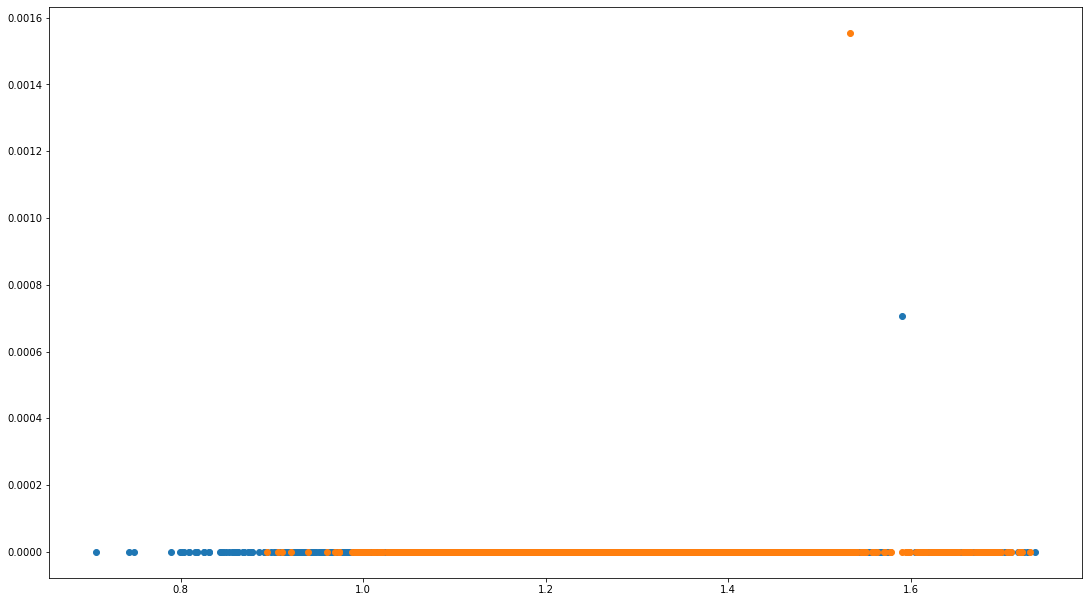

In [67]:
# xUnmatched = eagleComp.ComparisonData['snapShot - 28 : Mass unmatched']
# xMatched = eagleComp.ComparisonData['snapShot - 28 : Mass 1']

xUnmatched = np.log10( eagleComp.ComparisonData['snapShot - 28 : Vmax unmatched'] )
xMatched = np.log10( eagleComp.ComparisonData['snapShot - 28 : Vmax 1'] )

yUnmatched =  eagleComp.ComparisonData['snapShot - 28 : SFR unmatched']
yMatched = eagleComp.ComparisonData['snapShot - 28 : SFR 1']

print(len(xMatched), len(xUnmatched))
n = 50

fig, axes = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)

axes.scatter(xUnmatched, yUnmatched)
axes.scatter(xMatched, yMatched)



fig.show()

# Measuring the scatter of each bin

